In [39]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.stats.stattools as smtools
import matplotlib.pyplot as plt
import numpy as np
import math
import re
import os
# from dotenv import load_dotenv
# load_dotenv()
# download_url = os.getenv('Download_URL')

##### Get Data

In [3]:
# !curl 'happ_file_curl' -o happiness.zip
# !curl 'temp_file_curl' -o daily_temp.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0curl: (6) Could not resolve host: happ_file_curl
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0curl: (6) Could not resolve host: temp_file_curl


In [46]:
# # !mkdir -p happiness_data && unzip -o happiness.zip -d happiness_data
# !mkdir -p temperature_data && unzip -o daily_temp.zip -d temperature_data

Archive:  daily_temp.zip
  inflating: temperature_data/city_temperature.csv  


##### Explore Data

In [3]:
# explore data
happiness_folder = "happiness_data"
filepaths = [os.path.join(happiness_folder, f) for f in os.listdir(happiness_folder)]
filepaths = sorted(filepaths)
print(filepaths)

happiness_df = pd.DataFrame()
for f in filepaths:
    temp_df = pd.read_csv(f)
    country_col = [col for col in temp_df.columns if "Country" in col][0]
    score_col = [col for col in temp_df.columns if "Score" in col][0]
    temp_df = temp_df[[country_col, score_col]]
    temp_df.columns = ['country', 'happiness_score']
    
    # extract year from filename
    match = re.search(r'(\d{4})', f)
    temp_df['year'] = match.group(1)
    
    happiness_df = pd.concat([happiness_df, temp_df])

happiness_df.sample(5)

['happiness_data/2015.csv', 'happiness_data/2016.csv', 'happiness_data/2017.csv', 'happiness_data/2018.csv', 'happiness_data/2019.csv']


,country,happiness_score,year
53,Latvia,5.850,2017
79,Pakistan,5.269,2017
42,Bahrain,6.105,2018
114,Bangladesh,4.500,2018
50,Japan,5.920,2017


In [4]:
# check duplicates
assert happiness_df[['country', 'year']].duplicated().sum() == 0

In [5]:
happiness_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 782 entries, 0 to 155
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country          782 non-null    object 
 1   happiness_score  782 non-null    float64
 2   year             782 non-null    object 
dtypes: float64(1), object(2)
memory usage: 24.4+ KB


In [6]:
# explore data
temperature_df = pd.read_csv("temperature_data/city_temperature.csv", low_memory=False)
temperature_df.columns = [col.lower() for col in temperature_df.columns] 
temperature_df['year'] = temperature_df['year'].astype(str) 
temperature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906327 entries, 0 to 2906326
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   region          object 
 1   country         object 
 2   state           object 
 3   city            object 
 4   month           int64  
 5   day             int64  
 6   year            object 
 7   avgtemperature  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 177.4+ MB


In [7]:
# get yearly avg temperature for each country
temperature_df = temperature_df.groupby(['country', 'year']).agg(
    avg_temp = ("avgtemperature", 'mean'),
    region = ("region", lambda x: x.unique()[0]),
    city = ("city", lambda x: x.unique()[0])
).reset_index()

temperature_df.head(2)

,country,year,avg_temp,region,city
0,Albania,1995,-99.0,Europe,Tirana
1,Albania,1996,-99.0,Europe,Tirana


In [8]:
print(happiness_df['country'].nunique())
print(temperature_df['country'].nunique())

170
125


We will take the countries that are present in both data set.

In [9]:
final_df = happiness_df.merge(temperature_df, how='left', left_on=['country', 'year'], right_on=['country', 'year'])\
    [['country', 'year', 'happiness_score', 'avg_temp', 'region', 'city']]
final_df = final_df.dropna()
final_df = final_df.sort_values(by='year')
final_df.sample(3)

,country,year,happiness_score,avg_temp,region,city
643,Belgium,2019,6.923,50.013425,Europe,Brussels
218,Belarus,2016,5.802,44.822951,Europe,Minsk
442,Ivory Coast,2017,4.180,81.254795,Africa,Abidjan


In [10]:
final_df.groupby('year').agg(
    avg_happiness=("happiness_score", "median"),
    avg_temp = ("avg_temp", "median")
)

,avg_happiness,avg_temp
year,,
2015,5.6605,62.943169
2016,5.7300,61.395082
2017,5.6940,63.922877
2018,5.5240,61.485863
2019,5.6480,61.511781


In [11]:
final_df.groupby('region').agg(
    n_countries = ('country', 'nunique')
)

,n_countries
region,
Africa,22
Asia,21
Australia/South Pacific,2
Europe,28
Middle East,10
North America,2
South/Central America & Carribean,16


Since we only have very few countries for some regions, they will not likely be representative for whole region (there are 23 countries in North America but we only have 2 in our data)

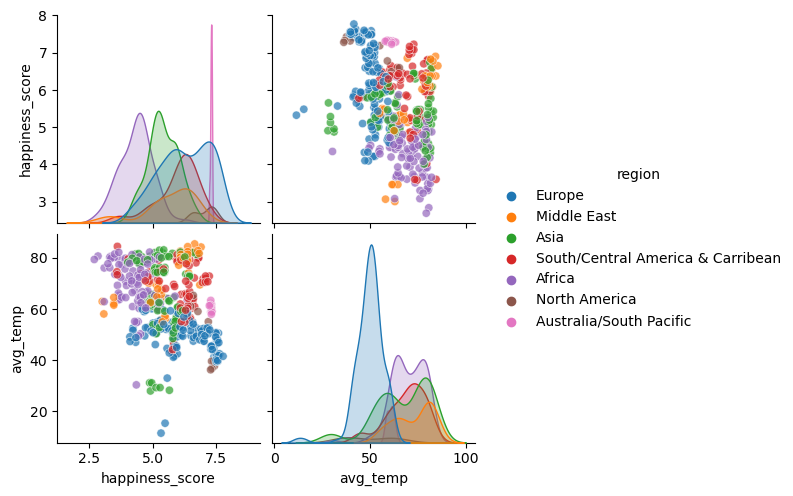

In [12]:
sns.pairplot(final_df, hue="region", plot_kws={'alpha': 0.7});

Through our selection of countries, the distribution of happiness scores is roughly normal with varying mean scores for each region.

Africa has the lowest average happiness score whereas Europe, Australia/South Pacific, and North America seems to have higher scores. Other regions varies around 6 and 7. Middle East have a significant left skew (a few countries with very low happiness scores) although majority have higher happiness score. The average temperature for Europe is significantly lower than other regions. 

There is no significant linear relationship between our variables and there is a noticeable spread of data points. We will explore further with regression analysis.


<i>For Linear Regression model to work, we generally need to check the following 4 assumptions.
- Linearity ( it would be preferable that independent variables have some form of linear relation to the dependent variable )
- Normality ( the residual errors are normally distributed ) 
- Independent observations ( for this assumption to be met, scores should not be influenced by other year's score or spacial influence by other country. To meet this assumption, we may need to check autocorrelations )
- Homoscedasticity ( the variance of the errors should be constant or similar across the model )

#### Model Creation

In [13]:
# test with overall model first

X = final_df[['avg_temp']] # independent vars 
y = final_df['happiness_score'] # dependent var

# add constant (since intercept is not included by default )
X = sm.add_constant(X)

# fit the model
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        happiness_score   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     69.81
Date:                Sun, 26 May 2024   Prob (F-statistic):           7.13e-16
Time:                        12:11:19   Log-Likelihood:                -700.63
No. Observations:                 480   AIC:                             1405.
Df Residuals:                     478   BIC:                             1414.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.4615      0.227     32.887      0.0

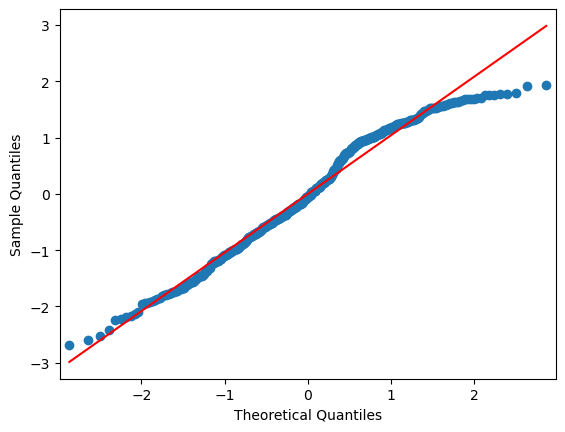

In [15]:
# Normality check

residuals = model.resid
fig = sm.qqplot(residuals, line = 's')
plt.show()

# fig = sns.histplot(residuals)
# fig.set_xlabel("Residual Value")
# fig.set_title("Histogram of Residuals")
# plt.show()

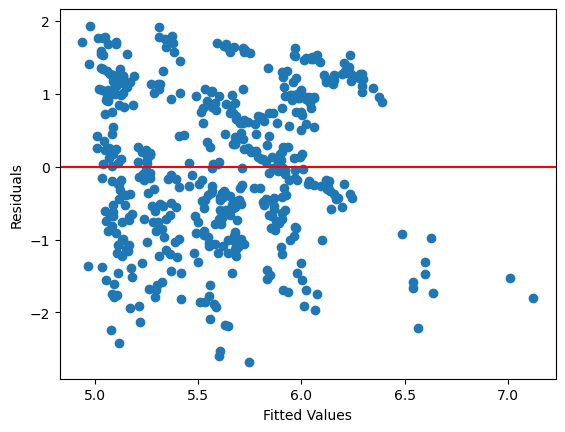

In [55]:
# check for Homoscedasticity
fig = plt.scatter(model.fittedvalues, model.resid)
ax = plt.gca()
ax.axhline(0, c='red')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

The model suggest the following relation
- intercept = 7.46
- slope = -0.0295
> $$
\text{happiness} = 7.46 + (-0.0295) \cdot \text{avg\_temp}
$$

meaning that every 1 degree increase in temperature will reduce the happiness score by around 0.0295 points, and for 95% of time, we can expect this coefficient ranging between -0.036 to -0.023. 

> R2 : 0.127 <br>
However, with the R^2 of 0.127, the model looks unpromising. Realistically, every degree of temperature change on global scale will have significant consequences and (effect of temperature increase on happiness score could even be exponential).

> Durbin-Watson statistics : 0.388
This indicates that the data has positive autocorrelation. Our data have temporal (our model should be isolated for each year) and spatial dependence on the happiness scores and observations may not be truely independent. To account for spatial dependence, we need to add more explainatory variables measuring the geopolitical, economic and other factors of each country.

In summary, our overall regression results is statistically significant with very small P-value indicating that we can reject the null hypothesis(no correlation between temperature and happiness) although there are issues with its predictive power due to the abovementioned factors. 

#### Check for Each Region

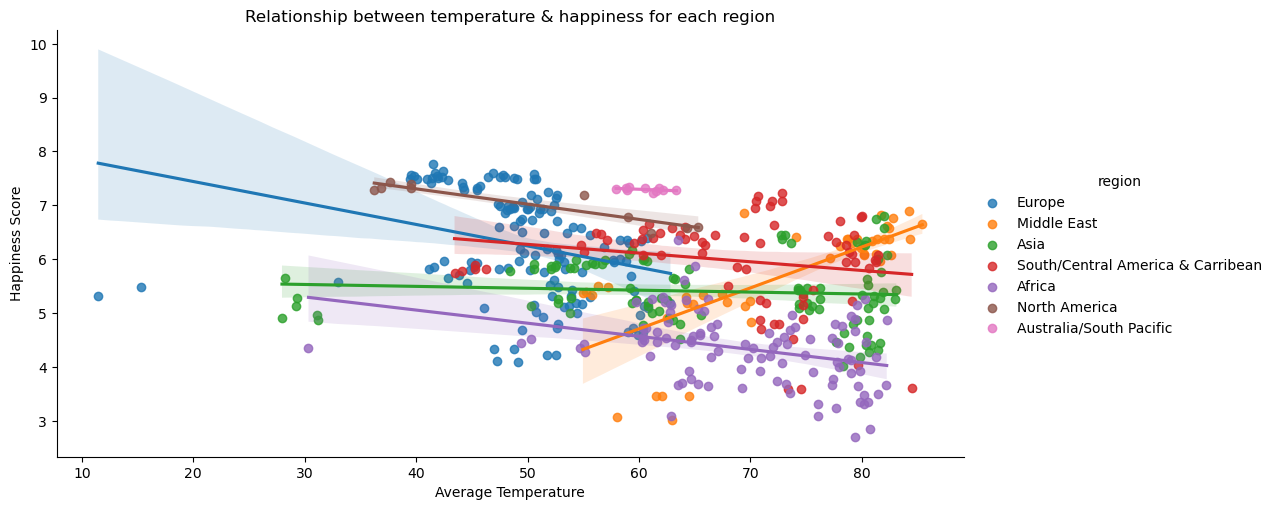

In [15]:
# plot the regression line
sns.lmplot(x='avg_temp', y='happiness_score', data=final_df, hue='region', aspect=2)
plt.xlabel('Average Temperature')
plt.ylabel('Happiness Score')
plt.title('Relationship between temperature & happiness for each region')
plt.show()

In [55]:
# no need to add constant manually when using formula API
# ols_formula = "happiness_score ~ avg_temp"
# OLS = ols(formula=ols_formula, data=final_df)
# m = OLS.fit()

# print(m.summary())

                            OLS Regression Results                            
Dep. Variable:        happiness_score   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     69.81
Date:                Sat, 25 May 2024   Prob (F-statistic):           7.13e-16
Time:                        14:28:45   Log-Likelihood:                -700.63
No. Observations:                 480   AIC:                             1405.
Df Residuals:                     478   BIC:                             1414.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4615      0.227     32.887      0.0

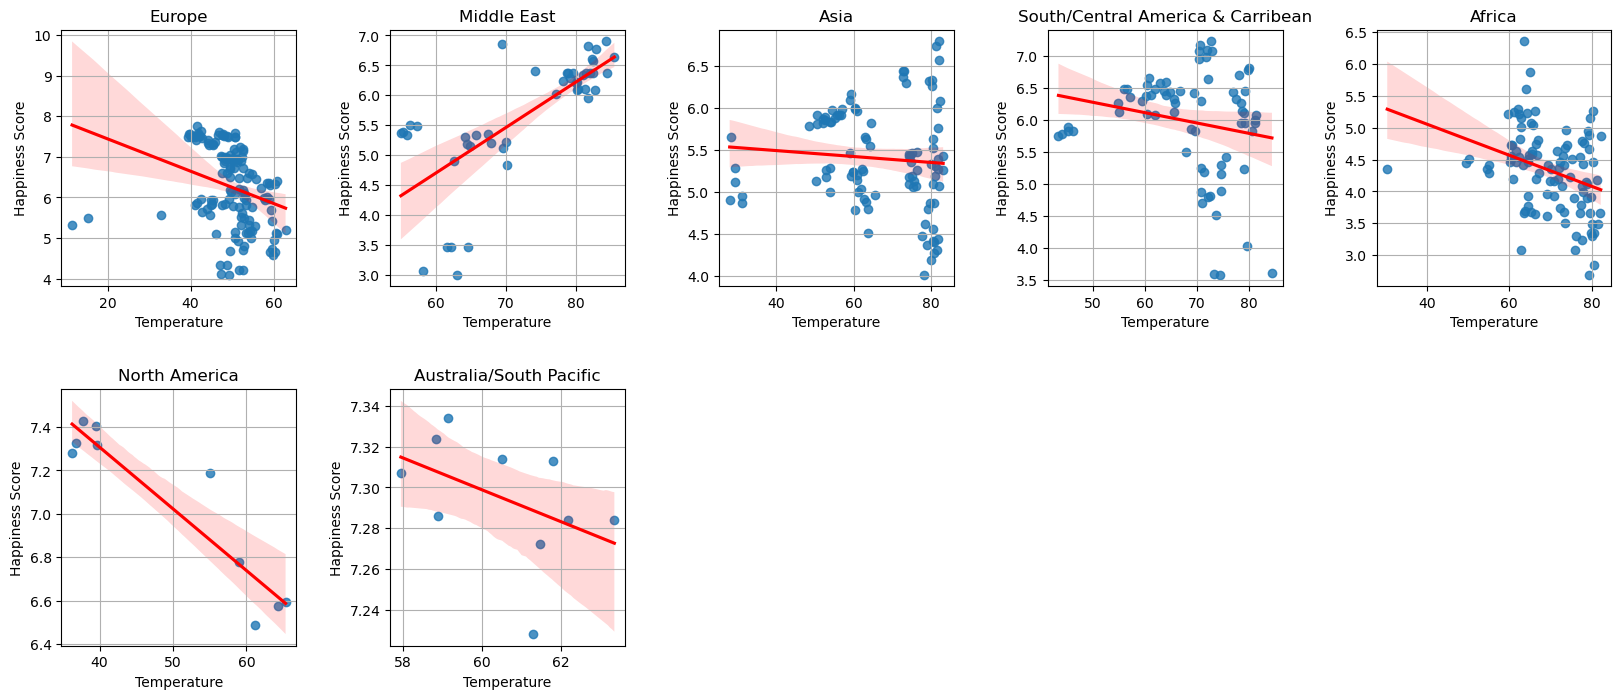

In [23]:
# to store the resulting models
results = {}

# focus_df = final_df[final_df['year']=="2019"].copy()
focus_df = final_df.copy()

# prep for plot
regions = focus_df['region'].unique()
n_regions = len(regions)
n_cols = 5
n_rows = math.ceil(n_regions/n_cols) # get num of rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
axes = axes.flatten()

# Iterate over each region
for i, region in enumerate(regions):
    region_data = focus_df[focus_df['region'] == region]
    region_data = region_data.sort_values(by='year')
    model = ols(formula='happiness_score ~ avg_temp', data=region_data).fit()
    results[region] = model
    
    sns.regplot(x='avg_temp', y='happiness_score', data=region_data, ax=axes[i], line_kws={"color": "red"})
    axes[i].set_title(f'{region}')
    axes[i].set_xlabel('Temperature')
    axes[i].set_ylabel('Happiness Score')
    axes[i].grid(True)

# remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

Except for Middle East region, we have negative correlation between temperature and happiness score. Therefore, temperature can be one of the predictors for happiness score. However, simple linear regression may not be appropriate since there are both positive and negative correlations in our data.

*<i>However, this correlation does not imply lower temperature makes people happier and that there are other factors (for example, people from rich countries are able afford air-condition, mitigating the effect of temperature, or, fair climates make people productive so they have more income and therefore happy. )

In [24]:
results

{'Europe': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f2c20660280>,
 'Middle East': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f2c206604f0>,
 'Asia': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f2bab132fb0>,
 'South/Central America & Carribean': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f2c2068c1c0>,
 'Africa': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f2c2068ded0>,
 'North America': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f2c206af070>,
 'Australia/South Pacific': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f2c21d33430>}

In [95]:
# Categorize countries based on the coefficient of Temperature
positive_corr = []
negative_corr = []
no_corr = []

for country, model in results.items():
    coef = model.params['avg_temp']
    p_value = model.pvalues['avg_temp']
    if p_value < 0.05:  # consider p-value < 0.05 as statistically significant
        if coef > 0:
            positive_corr.append(country)
        else:
            negative_corr.append(country)
    else:
        no_corr.append(country)

print("Positive Correlation:", positive_corr)
print("Negative Correlation:", negative_corr)
print("No Correlation:", no_corr)


Positive Correlation: ['Middle East']
Negative Correlation: ['Europe', 'Africa', 'North America']
No Correlation: ['Asia', 'South/Central America & Carribean', 'Australia/South Pacific']


In [16]:
# try multilevel model

mx_model = smf.mixedlm("happiness_score ~ avg_temp", final_df, groups=final_df['region'])
result = mx_model.fit()
print(result.summary())

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: happiness_score
No. Observations: 480     Method:             REML           
No. Groups:       7       Scale:              0.6488         
Min. group size:  10      Log-Likelihood:     -595.6271      
Max. group size:  139     Converged:          Yes            
Mean group size:  68.6                                       
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       6.487     0.425  15.253  0.000   5.653   7.320
avg_temp       -0.008     0.004  -2.222  0.026  -0.015  -0.001
Group Var       0.874     0.656                               



According to the Mixed model, the intercept for happiness score is 6.487 with -0.008 point decrease for every unit of temperature increase. Since group variance is 0.874, it confirms the high variance in happiness score across the groups.

In [ ]:
# # by country 

# results = {}

# # prep for plot
# countries = final_df['country'].unique()
# n_countries = len(countries)
# n_cols = 5
# n_rows = math.ceil(n_countries/n_cols) # get num of rows needed
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
# axes = axes.flatten()

# # Iterate over each country
# for i, country in enumerate(countries):
#     country_data = final_df[final_df['country'] == country]
#     country_data = country_data.sort_values(by='year')
#     c_model = ols(formula='happiness_score ~ avg_temp', data=country_data).fit()
#     results[country] = c_model
    
#     sns.regplot(x='avg_temp', y='happiness_score', data=country_data, ax=axes[i], line_kws={"color": "red"})
#     axes[i].set_title(f'{country}')
#     axes[i].set_xlabel('Temperature')
#     axes[i].set_ylabel('Happiness Score')
#     axes[i].grid(True)

# # remove unused subplots
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])
# plt.subplots_adjust(hspace=0.4, wspace=0.4)
# plt.show()

# # Categorize countries based on the coefficient of Temperature
# positive_corr = []
# negative_corr = []
# no_corr = []

# for country, model in results.items():
#     coef = model.params['avg_temp']
#     p_value = model.pvalues['avg_temp']
#     if p_value < 0.05:  # Considering p-value < 0.05 as statistically significant
#         if coef > 0:
#             positive_corr.append(country)
#         else:
#             negative_corr.append(country)
#     else:
#         no_corr.append(country)

# print("Positive Correlation:", positive_corr)
# print("Negative Correlation:", negative_corr)
# print("No Correlation:", no_corr)
